# Road Network

Data source: https://osdatahub.os.uk/downloads/open/OpenRoads

In [1]:
from os import listdir, path

import shapely
import pandas as pd
import geopandas as gpd

from lets_plot import *
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



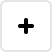
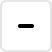
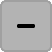
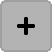
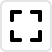
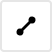
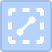
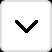
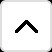
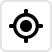

In [2]:
LetsPlot.setup_html()

In [3]:
COUNTY_NAME = "City of Nottingham"
INPUT_DIR = "data"
DATA_IDS = ["SK"]

In [4]:
def data_files(input_dir):
    return {
        filename[:2]: path.join(input_dir, filename)
        for filename in listdir(input_dir)
        if filename[3:] == "RoadLink.shp"
    }

def load_dataset(fullpath, outer_geom=None):
    gdf = gpd.read_file(fullpath)
    gdf = gdf[["geometry", "length"]] # remove extra columns
    gdf = gdf.to_crs(4326) # transform coordinates to EPSG:4326
    if outer_geom is not None:
        gdf = gdf[gdf["geometry"].intersects(outer_geom)] # restrict paths by outer geometry
    gdf["geometry"] = gdf["geometry"].apply(
        lambda v: shapely.wkb.loads(shapely.wkb.dumps(v, output_dimension=2))
    ) # remove extra third coordinate (that is always 0)
    return gdf

def get_gdf(input_dir, *, outer_geom=None, input_slice=None):
    if input_slice is None:
        data_files_slice = data_files(input_dir)
    else:
        data_files_slice = {k: v for k, v in data_files(input_dir).items() if k in input_slice}
    return gpd.GeoDataFrame(pd.concat([
        load_dataset(fullpath, outer_geom).assign(id=file_id)
        for file_id, fullpath in data_files_slice.items()
    ], ignore_index=True))

In [5]:
county_geometry = geocode_counties(COUNTY_NAME).get_boundaries(15).iloc[0].geometry
county_geometry

In [6]:
roads_gdf = get_gdf(INPUT_DIR, outer_geom=county_geometry, input_slice=DATA_IDS)
print(roads_gdf.shape)
roads_gdf.head()

(10164, 3)


geometry  length  id
0  LINESTRING (-1.18751 52.93045, -1.18668 52.930...     248  SK
1  LINESTRING (-1.18509 52.93213, -1.18487 52.932...      43  SK
2  LINESTRING (-1.18465 52.93241, -1.18472 52.932...      45  SK
3  LINESTRING (-1.18465 52.93241, -1.18461 52.932...       7  SK
4  LINESTRING (-1.18458 52.93246, -1.18384 52.932...     155  SK

In [7]:
ggplot() + \
    geom_path(aes(color="length"), map=roads_gdf) + \
    scale_color_gradient(low="#8856a7", high="#e0ecf4", \
                         trans="log10", guide='none') + \
    ggsize(800, 800) + \
    ggtitle("{0} road network".format(COUNTY_NAME)) + \
    theme_classic() + theme(axis='blank') + flavor_high_contrast_dark()